In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config
from spacy.lang.en import English
import spacy
spacy.prefer_gpu()
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Concatenate,GlobalMaxPool2D,Multiply
from tensorflow.keras.layers import Dropout, Subtract, Add, GlobalAvgPool2D, Conv2D, Bidirectional
from tensorflow.keras.layers import Flatten, Dense, Embedding, LSTM, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Concatenate, Lambda,concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.initializers import glorot_uniform, Constant
from sklearn.model_selection import train_test_split
import os
import json

In [2]:
print("Loading training file from path: ", config.config_io.get('pan_19_processed_train')) # pan_20_processed_train_wide
training_data = pd.read_csv(config.config_io.get('pan_19_processed_train'))
training_data.head()

Loading training file from path:  /home/sukanya/PhD/Datasets/PAN SCD/pan19-style-change-detection/processed/train.csv


,problem,author_1,author_2,para1_text,para2_text
0,problem-1543.txt,A1,A1,Given an alphabet $\Sigma$ of size $k$ and two...,"\nThe paper ""Algorithmic Meta Theorems for Cir..."
1,problem-631.txt,A1,A3,"\nInstead of an actual GPS device, I would rec...","In the end, a seat post pump probably has the ..."
2,problem-631.txt,A3,A2,"In the end, a seat post pump probably has the ...",\nThanks for the help. Finally what I needed t...
3,problem-631.txt,A2,A1,\nThanks for the help. Finally what I needed t...,"\nIt might sound weird, but if you're finding ..."
4,problem-631.txt,A1,A2,"\nIt might sound weird, but if you're finding ...",This is a bit weird question. I bought a Speci...


In [3]:
training_data.shape

(18961, 5)

In [4]:
sum(training_data['author_1']== training_data['author_2'])/len(training_data)

0.5795053003533569

In [5]:
combined = training_data["para1_text"] + " " + training_data["para2_text"]

In [6]:
max_words = 10000
t = Tokenizer(num_words=max_words, oov_token="<OOV>")
t.fit_on_texts(combined.values)


In [7]:
max_len = 300

We see that most of the values are less than say len 100, so we can infact try with length 200 and see how that goes

In [8]:
embeddings_index = {}
f = open('/home/sukanya/PhD/Embeddings/Glove/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [9]:
def get_glove_embed_matrix(t, embeddings_index, embedding_vector_size = 50):
    """
    t: tokenizer
    
    """
    not_present_list = []
    vocab_size = len(t.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
    for word, i in t.word_index.items():
        embedding_vector = None
        if word in embeddings_index.keys():
            embedding_vector = embeddings_index.get(word)
        else:
            not_present_list.append(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.zeros(embedding_vector_size) # size of the embedding
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embedding_matrix

In [10]:
embedding_dim = 50
embed_matrix = get_glove_embed_matrix(t, embeddings_index, embedding_vector_size = embedding_dim)

Loaded 400000 word vectors.


In [11]:
embed_matrix.shape

(56176, 50)

In [12]:
from src.DataGeneratorSiamese import DataGeneratorSiamese
len_train = len(training_data)
#
#
training_generator = DataGeneratorSiamese(training_data.iloc[0:int(0.8*len_train)], tokenizer=t,max_len=max_len, batch_size=64)
validation_generator = DataGeneratorSiamese(training_data.iloc[int(0.8*len_train):], tokenizer=t, max_len=max_len, batch_size=64)

# this is a hack for "'DataGenerator' object has no attribute 'index'". It turns out that on_epoch_end creates the index that is used
training_generator.on_epoch_end()
validation_generator.on_epoch_end()

In [13]:
def manh_lstm_distance(left, right):
    distance = tf.keras.backend.abs(left-right)
    distance = tf.keras.backend.sum(distance, axis=1, keepdims=True)
    distance = -distance
    distance = tf.keras.backend.exp(distance)
    return distance

In [14]:
def exponent_neg_cosine_distance(left,right):
    left = tf.keras.backend.l2_normalize(left, axis=-1)
    right = tf.keras.backend.l2_normalize(right, axis=-1)
    return tf.keras.backend.exp(tf.keras.backend.sum(tf.keras.backend.prod([left, right], axis=0), axis=1, keepdims=True))

In [15]:
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return tf.keras.backend.exp.exp(-tf.keras.backend.exp.sum(tf.keras.backend.exp.abs(left-right), axis=1, keepdims=True))

In [16]:
def exponent_neg_euclidean_distance(left, right):
    distance = tf.keras.backend.square(left-right)
    distance = tf.keras.backend.sum(distance, axis=1, keepdims=True)
    distance = tf.keras.backend.sqrt(distance, axis = 1, keepdims = True)
    distance = tf.keras.backend.exp(-distance)
    return distance

In [17]:
input_1 = Input(shape=(max_len,))#(train_p1_seq.shape[1],)
input_2 = Input(shape=(max_len,))


lstm_layer = Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
#lstm_layer = tf.keras.layers.LSTM(50, name="common_lstm_layer")
# max_words 10000 , embedding_dim = 50, max_len = 300
embeddings_initializer = Constant(embed_matrix)
emb =  Embedding(len(t.word_index)+1, 
                 embedding_dim, 
                 embeddings_initializer=embeddings_initializer,
                 input_length=max_len, 
                 weights=[embed_matrix],
                 trainable=True)

e1 = emb(input_1)
x1 = lstm_layer(e1)

e2 = emb(input_2)
x2 = lstm_layer(e2)

#concats = concatenate([x1, x2], axis=-1)
#merged = Lambda(exponent_neg_cosine_distance, output_shape=(1,))(concats)

mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) #manh_lstm_distance
merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='L1_distance')([x1, x2])
preds = Dense(1, activation='sigmoid')(merged)
model = Model(inputs=[input_1, input_2], outputs=preds)
model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(clipnorm=1.5))


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 50)      2808800     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100)          40400       embedding[0][0]              

In [19]:
history = model.fit(training_generator, validation_data=validation_generator, verbose=1, batch_size=64, 
                             epochs=30, steps_per_epoch=100) #, callbacks=[callback]

Epoch 1/30
100/100 [==============================] - 37s 325ms/step - loss: 0.9161 - acc: 0.3945 - val_loss: 0.7917 - val_acc: 0.4203
Epoch 2/30
100/100 [==============================] - 35s 347ms/step - loss: 0.7763 - acc: 0.4178 - val_loss: 0.7592 - val_acc: 0.4203
Epoch 3/30
100/100 [==============================] - 34s 337ms/step - loss: 0.7362 - acc: 0.4426 - val_loss: 0.7358 - val_acc: 0.4203
Epoch 4/30
100/100 [==============================] - 33s 335ms/step - loss: 0.7262 - acc: 0.4098 - val_loss: 0.7163 - val_acc: 0.4221
Epoch 5/30
100/100 [==============================] - 34s 342ms/step - loss: 0.7080 - acc: 0.4267 - val_loss: 0.7039 - val_acc: 0.4650
Epoch 6/30
100/100 [==============================] - 34s 337ms/step - loss: 0.6941 - acc: 0.5055 - val_loss: 0.6962 - val_acc: 0.5019
Epoch 7/30
100/100 [==============================] - 34s 342ms/step - loss: 0.6865 - acc: 0.5702 - val_loss: 0.6910 - val_acc: 0.5392
Epoch 8/30
100/100 [==============================] - 3

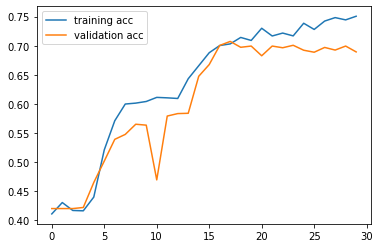

In [20]:
acc = pd.DataFrame({"training acc":history.history['acc'], 
                            "validation acc": history.history['val_acc']})
acc.plot()

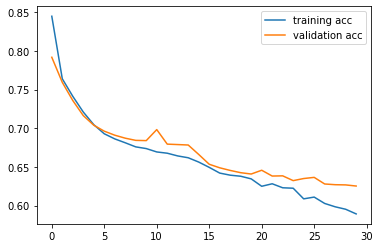

In [21]:
loss = pd.DataFrame({"training acc":history.history['loss'], 
                            "validation acc": history.history['val_loss']})
loss.plot()

In [22]:
testing_data = pd.read_csv(config.config_io.get('pan_19_processed_test'))
testing_generator = DataGeneratorSiamese(testing_data, tokenizer=t, max_len=max_len, batch_size=64)
testing_generator.on_epoch_end()

In [23]:
test_loss, test_acc = model.evaluate(testing_generator)

149/149 [==============================] - 7s 45ms/step - loss: 0.6220 - acc: 0.6966
